In [2]:
import numpy as np
import sklearn as sk
import pylab as plt
import pandas as pd
import os
import torch
from tqdm.auto import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
datadir = '/Users/ANONYMOUS/tmp/data/UCI/data'

def get_uci_info():
    info = []
    for idx, dataset in enumerate(sorted(os.listdir(datadir))):
        if not os.path.isdir(datadir + "/" + dataset):
            continue
        if not os.path.isfile(datadir + "/" + dataset + "/" + dataset + ".txt"):
            continue
        dic = dict()
        for k, v in map(lambda x : x.split(), open(datadir + "/" + dataset + "/" + dataset + ".txt", "r").readlines()):
            dic[k] = v
        c = int(dic["n_clases="])
        d = int(dic["n_entradas="])
        n_train = int(dic["n_patrons_entrena="])
        n_val = int(dic["n_patrons_valida="])
        n_train_val = int(dic["n_patrons1="])
        n_test = 0
        if "n_patrons2=" in dic:
            n_test = int(dic["n_patrons2="])
        n_tot = n_train_val + n_test
        
        p = dict(
            name=dataset,
            n = n_tot,
             num_classes=c,
             num_features=d
             )
            
        info.append(p)

    return pd.DataFrame(info)


def load_uci(dataset : str):
    dic = dict() 
    for k, v in map(lambda x : x.split(), open(datadir + "/" + dataset + "/" + dataset + ".txt", "r").readlines()):
        dic[k] = v
    c = int(dic["n_clases="])
    d = int(dic["n_entradas="])
    n_train = int(dic["n_patrons_entrena="])
    n_val = int(dic["n_patrons_valida="])
    n_train_val = int(dic["n_patrons1="])
    n_test = 0
    if "n_patrons2=" in dic:
        n_test = int(dic["n_patrons2="])
    n_tot = n_train_val + n_test
    
    def load_dat(sub_name):
        f = open(datadir + '/' + dataset + "/" + sub_name, "r").readlines()[1:]
        X = np.asarray(list(map(lambda x: list(map(float, x.split()[1:-1])), f)))
        y = np.asarray(list(map(lambda x: int(x.split()[-1]), f)))
        return X, y
        
    X, y = load_dat(dic["fich1="])
    if n_test > 0: # if a test set is provided, add its samples too.
        X2, y2 = load_dat(dic["fich2="])
        X = np.concatenate((X, X2))
        y = np.concatenate((y, y2))    
    
    fold = list(map(lambda x: list(map(int, x.split())), open(datadir + "/" + dataset + "/" + "conxuntos_kfold.dat", "r").readlines()))
    #len(fold) == 8. Includes 4 cross-val splits.
    
    p = dict(n = n_tot,
             num_classes=c,
             num_features=d,
             X=X,
             y=y,
             train_fold=fold[0],
             test_fold=fold[1],
             folds=fold,
             )
    return p

In [4]:
uci = get_uci_info()

In [5]:
uci[(uci['n'] >= 500) & (uci['num_classes'] >= 2)].sort_values('n')

,name,n,num_classes,num_features
27,cylinder-bands,512,2,35
53,low-res-spect,531,9,100
63,monks-3,554,2,6
61,monks-1,556,2,6
13,breast-cancer-wisc-diag,569,2,30
...,...,...,...,...
19,chess-krvk,28056,18,6
3,adult,48842,2,14
101,statlog-shuttle,58000,7,9
24,connect-4,67557,2,42


In [81]:
d = load_uci('molec-biol-splice')
[np.sum(d['y'] == i) for i in range(d['num_classes'])]

[767, 768, 1655]

In [152]:
def train(x, y, trees=1):
    clf = RandomForestClassifier(random_state=0, n_estimators=trees, bootstrap=False) 
    clf.fit(x, y)
    return clf

def joint_density(Y, L, num_classes=None):
    '''
        Estimates the joint density of (Y, L)
        where Y \in [nY],  L \in [nL].

        In other words, returns the confusion matrix.
    '''
    if num_classes is None:
        nY=np.max(Y)+1
        nL=np.max(L)+1
    else:
        nY = nL = num_classes
        
    C = np.zeros((nY, nL))
    for yhat, ell in zip(Y, L):
        C[yhat, ell] += 1
    C /= np.sum(C)
    return C

def apply_noise(Y, confusion_matx):
    C = torch.Tensor(confusion_matx)  # C[i, j] = Pr[j --> i]
    Y_new = np.empty_like(Y)
    for i in range(len(Y)):
        y = Y[i]
        p = C[:, y]
        yNew = torch.distributions.categorical.Categorical(probs=p).sample()
        #print(p)
        Y_new[i] = yNew
    return Y_new

In [176]:
## Misc scratch

def get_acc(name):
    d = load_uci(name) 
    X = d['X']
    y = d['y']
    n = d['n']
    I_tr = d['train_fold']
    I_te = d['test_fold']
    X_tr, y_tr = X[I_tr], y[I_tr]
    X_te, y_te = X[I_te], y[I_te]
    nc = d['num_classes']

    f = train(X_tr, y_tr)
    preds = f.predict(X_te)

    acc = (preds == y_te).mean()
    return acc

#get_acc('wine-quality-red')

ds = uci[(uci['n'] >= 500) & (uci['num_classes'] >= 2)]
accs = [get_acc(n) for n in tqdm(ds['name'])]

In [170]:
d = load_uci('molec-biol-splice') # dermatology
X = d['X']
y = d['y']
n = d['n']

I_tr = d['train_fold']
I_te = d['test_fold']
X_tr, y_tr = X[I_tr], y[I_tr]
X_te, y_te = X[I_te], y[I_te]

nc = d['num_classes']
# C[i, j] = Pr[j --> i]
C = np.eye(nc)
C[2, 2] = 0.7
C[1, 2] = 0.3
C[0, 2] = 0.0
y_tr_orig = np.copy(y_tr)
y_tr = apply_noise(y_tr_orig, C)

print('len(tr):', len(y_tr))
print('len(te):', len(y_te))

f = train(X_tr, y_tr)
preds = f.predict(X_te)

print('train acc:', (f.predict(X_tr) == y_tr).mean())
print('acc:', (preds == y_te).mean())

len(tr): 2393
len(te): 797
train acc: 0.9995821145006268
acc: 0.6725219573400251


Text(0.5, 1.0, 'Joint Density (Test)')

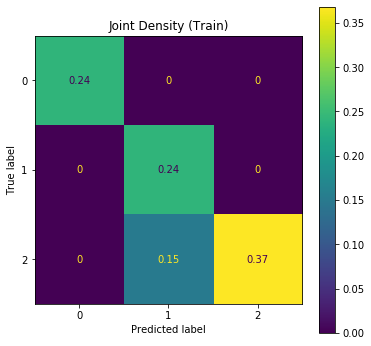

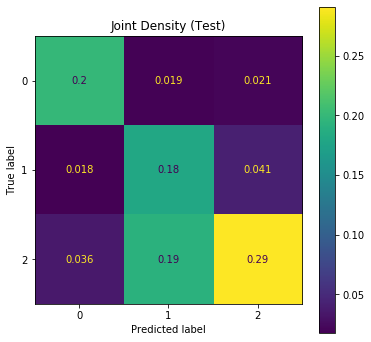

In [171]:
cm_tr = joint_density(f.predict(X_tr), y_tr_orig)
cm_te = joint_density(preds, y_te)

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(cm_tr.T, display_labels=[f'{i}' for i in range(d['num_classes'])])
disp.plot(ax=ax)
ax.set_title('Joint Density (Train)')

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(cm_te.T, display_labels=[f'{i}' for i in range(d['num_classes'])])
disp.plot(ax=ax)
ax.set_title('Joint Density (Test)')

len(tr): 1595
len(te): 531
train acc: 0.9987460815047022
acc: 0.8888888888888888


## Auto plot

In [156]:
def plot_confusion(cm, display_labels=None, include_values=True, cmap='viridis',
         xticks_rotation='horizontal', values_format=None, ax=None):
    """Plot visualization. 
    https://github.com/scikit-learn/scikit-learn/blob/483cd3eaa/sklearn/metrics/_plot/confusion_matrix.py#L11
    
    Parameters
    ----------
    include_values : bool, default=True
        Includes values in confusion matrix.
    cmap : str or matplotlib Colormap, default='viridis'
        Colormap recognized by matplotlib.
    xticks_rotation : {'vertical', 'horizontal'} or float, \
                     default='horizontal'
        Rotation of xtick labels.
    values_format : str, default=None
        Format specification for values in confusion matrix. If `None`,
        the format specification is 'd' or '.2g' whichever is shorter.
    ax : matplotlib axes, default=None
        Axes object to plot on. If `None`, a new figure and axes is
        created.
    """
    cm = cm.T # TRANSPOSE
    n_classes = cm.shape[0]
    
    import matplotlib.pyplot as plt
    from itertools import product

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    im_ = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    text_ = None
    cmap_min, cmap_max = im_.cmap(0), im_.cmap(256)

    if include_values:
        text_ = np.empty_like(cm, dtype=object)

        # print text with appropriate color depending on background
        thresh = (cm.max() + cm.min()) / 2.0

        for i, j in product(range(n_classes), range(n_classes)):
            color = cmap_max if cm[i, j] < thresh else cmap_min

            if values_format is None:
                text_cm = format(cm[i, j], '.2g')
                if cm.dtype.kind != 'f':
                    text_d = format(cm[i, j], 'd')
                    if len(text_d) < len(text_cm):
                        text_cm = text_d
            else:
                text_cm = format(cm[i, j], values_format)

            text_[i, j] = ax.text(
                j, i, text_cm,
                ha="center", va="center",
                color=color)

    if display_labels is None:
        display_labels = np.arange(n_classes)

    #fig.colorbar(self.im_, ax=ax)
    ax.set(xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=display_labels,
           yticklabels=display_labels,
           ylabel="True label",
           xlabel="Predicted label")

    ax.set_ylim((n_classes - 0.5, -0.5))
    plt.setp(ax.get_xticklabels(), rotation=xticks_rotation)

    return (fig, ax)

train acc: 0.9995821145006268
acc: 0.7867001254705144
train acc: 0.9995821145006268
acc: 0.6825595984943539
train acc: 0.9995821145006268
acc: 0.5759096612296111
train acc: 1.0
acc: 0.5282308657465495
train acc: 1.0
acc: 0.40526976160602257


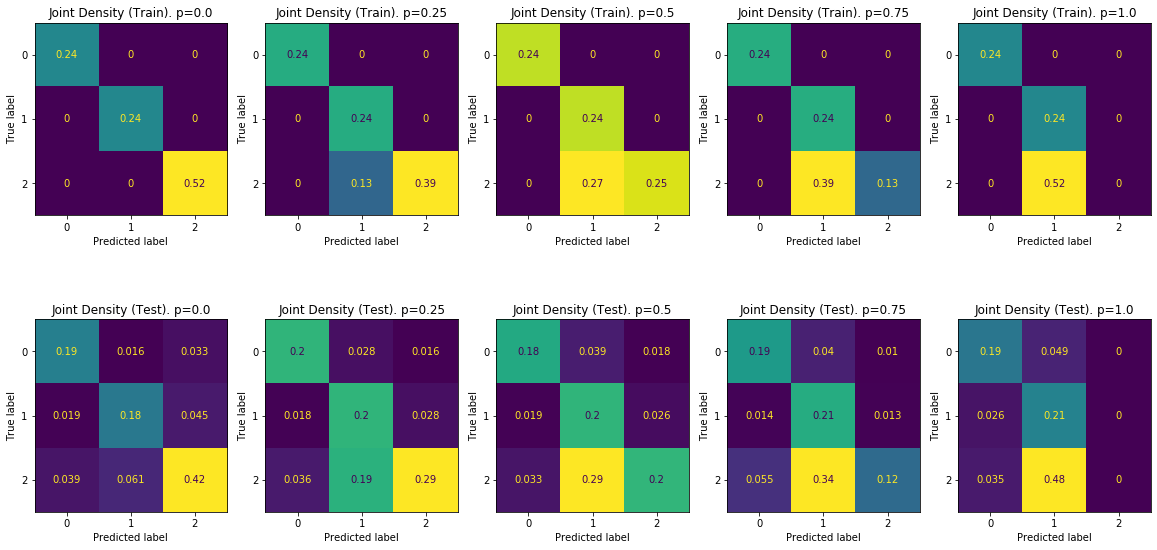

In [166]:
ntrees=1 # doesn't hold for Random Forest
d = load_uci('molec-biol-splice') # dermatology
X = d['X']
y = d['y']
n = d['n']
nc = d['num_classes']

I_tr = d['train_fold']
I_te = d['test_fold']
X_tr, y_tr = X[I_tr], y[I_tr]
X_te, y_te = X[I_te], y[I_te]
y_tr_orig = np.copy(y_tr)

def getC(p=0.3):
    # C[i, j] = Pr[j --> i]
    C = np.eye(nc)
    C[2, 2] = (1-p)
    C[1, 2] = p
    C[0, 2] = 0.0
    return C

gammas = np.linspace(0, 1.0, 5)
fig, axs = plt.subplots(2, len(gammas), figsize=(20, 10))
    
for i, g in enumerate(gammas):
    C = getC(g)
    y_tr = apply_noise(y_tr_orig, C)

    f = train(X_tr, y_tr, trees=ntrees)
    preds = f.predict(X_te)

    print('train acc:', (f.predict(X_tr) == y_tr).mean())
    print('acc:', (preds == y_te).mean())

    #cm_tr = joint_density(f.predict(X_tr), y_tr_orig, num_classes=nc)
    cm_tr = joint_density(y_tr, y_tr_orig, num_classes=nc)
    cm_te = joint_density(preds, y_te, num_classes=nc)

    plot_confusion(cm_tr, ax=axs[0, i], display_labels=None)
    axs[0, i].set_title(f'Joint Density (Train). p={g}')
    plot_confusion(cm_te, ax=axs[1, i], display_labels=None)
    axs[1, i].set_title(f'Joint Density (Test). p={g}')


In [168]:
fig.savefig('uci_confusion.png')